In [56]:
import ezomero as ez
import omero
from omero.rtypes import rstring, unwrap
from getpass import getpass
import numpy as np

In [4]:
USER = "participant-a"
PWD = getpass(prompt=f"Password for {USER}")
OMERO_GROUP = "Workshop Metadata Annotation"
HOST = "wss://omero-training.gerbi-gmb.de/omero-wss"
PORT = 443

Password for participant-a ········


# A first HQL query

In [65]:
q = """
SELECT img.id, img.name
FROM Image AS img 
JOIN img.datasetLinks AS dl
JOIN dl.parent AS dset
WHERE dset.id = :dsetid
"""

with ez.connect(USER, PWD, group=OMERO_GROUP, host=HOST, port=PORT, secure=True) as conn:
    qs = conn.getQueryService()
    params = omero.sys.ParametersI()
    params.addLong("dsetid", 241)
    
    res = qs.projection(q, params)
res

[[object #0 (::omero::RLong)
  {
      _val = 7541
  },
  object #0 (::omero::RString)
  {
      _val = EH-15740-048.svs [0]
  }],
 [object #0 (::omero::RLong)
  {
      _val = 7542
  },
  object #0 (::omero::RString)
  {
      _val = EH-15740-048.svs [label image]
  }],
 [object #0 (::omero::RLong)
  {
      _val = 7544
  },
  object #0 (::omero::RString)
  {
      _val = EH-15740.svs [label image]
  }],
 [object #0 (::omero::RLong)
  {
      _val = 7547
  },
  object #0 (::omero::RString)
  {
      _val = EH-15740.svs [0]
  }],
 [object #0 (::omero::RLong)
  {
      _val = 7548
  },
  object #0 (::omero::RString)
  {
      _val = EH-15740.svs [macro image]
  }],
 [object #0 (::omero::RLong)
  {
      _val = 7546
  },
  object #0 (::omero::RString)
  {
      _val = EH-15740-048.svs [macro image]
  }],
 [object #0 (::omero::RLong)
  {
      _val = 7549
  },
  object #0 (::omero::RString)
  {
      _val = EH-15740-047.svs [0]
  }],
 [object #0 (::omero::RLong)
  {
      _val = 7545
  },

In [16]:
for row in res:
    print(unwrap(row))

[7541, 'EH-15740-048.svs [0]']
[7542, 'EH-15740-048.svs [label image]']
[7544, 'EH-15740.svs [label image]']
[7547, 'EH-15740.svs [0]']
[7548, 'EH-15740.svs [macro image]']
[7546, 'EH-15740-048.svs [macro image]']
[7549, 'EH-15740-047.svs [0]']
[7545, 'EH-15740-047.svs [label image]']
[7543, 'EH-15740-047.svs [macro image]']


# Going through the OME model

https://docs.openmicroscopy.org/omero/5.4.0/developers/Model/EveryObject.html

Find the full path from a project to an image:<br/>
starting point: https://docs.openmicroscopy.org/omero/5.4.0/developers/Model/EveryObject.html#project

SOLUTION


Project.datasetLinks -> ProjectDatasetLink.child -> Dataset.imageLinks -> DatasetImageLink.child -> Image

Find the opposite path, from an image to a project

SOLUTION


Image.datasetLinks -> DatasetImageLink.parent -> Dataset.projectLinks -> ProjectDatasetLink.parent -> Project

Let's make it an HQL Query: for a given project ID, let's get all images id, name and associated dataset name

In [66]:
q = """
SELECT img.id, img.name, dset.name
FROM Project AS proj
JOIN proj.datasetLinks AS dl
JOIN dl.child AS dset
JOIN dset.imageLinks AS il
JOIN il.child AS img
WHERE proj.id = :projid
"""

with ez.connect(USER, PWD, group=OMERO_GROUP, host=HOST, port=PORT, secure=True) as conn:
    qs = conn.getQueryService()
    params = omero.sys.ParametersI()
    params.addLong("projid", 46)
    
    res = qs.projection(q, params)
unwrap(res[0])

[7540, 'embryo07_stain.ome.tiff', 'z-stack']

# A more useful query: get many ROIs at once

For a given dataset, retrieve all shapes for all images

In [80]:
q = """
SELECT img.id, s.points, s.textValue
FROM Dataset dset
JOIN dset.imageLinks il
JOIN il.child img
JOIN img.rois r
JOIN r.shapes s
WHERE dset.id = :dsetid AND s.class = Polygon
"""

with ez.connect(USER, PWD, group=OMERO_GROUP, host=HOST, port=PORT, secure=True) as conn:
    qs = conn.getQueryService()
    params = omero.sys.ParametersI()
    params.addLong("dsetid", 241)
    
    res = qs.projection(q, params)
unwrap(res[0])

[7549,
 '74199.02107745942,4899.436998181409 71741.20223996844,2384.0126168013717 69436.99659912588,2672.0385050285026 68707.33199226682,3344.0983004857703 66268.71347672374,6454.775695877046 66287.91562988977,7165.240713275443 66883.16955951008,8528.560626137896 67708.84200225034,10583.14431884177 69475.39980672707,13328.989484052237 70877.12585713972,15998.026512715269 72758.89291817645,18455.845789698604 74026.20755886307,19070.301359743866 75005.49356449538,19627.150983032094 76023.1845356983,20625.641192794734 76925.66742232081,21355.304700922934 78577.01230780134,21950.558630543237 80151.55224305396,22680.22396988955 81246.05102118505,22833.837459532882 81687.68955669517,21412.91108717232 81937.31022298118,19435.133260305418 81687.68955669517,18302.232776171986 81034.83099879489,17034.919966703477 80228.36254043877,16074.834283019081 79748.31969859658,15844.413938680998 79249.07287237022,15287.56523100183 78423.39859841185,15460.379115841806 77712.93541223157,15690.800375788946 7

In [82]:
coords = unwrap(res[0])[1]
coords

'74199.02107745942,4899.436998181409 71741.20223996844,2384.0126168013717 69436.99659912588,2672.0385050285026 68707.33199226682,3344.0983004857703 66268.71347672374,6454.775695877046 66287.91562988977,7165.240713275443 66883.16955951008,8528.560626137896 67708.84200225034,10583.14431884177 69475.39980672707,13328.989484052237 70877.12585713972,15998.026512715269 72758.89291817645,18455.845789698604 74026.20755886307,19070.301359743866 75005.49356449538,19627.150983032094 76023.1845356983,20625.641192794734 76925.66742232081,21355.304700922934 78577.01230780134,21950.558630543237 80151.55224305396,22680.22396988955 81246.05102118505,22833.837459532882 81687.68955669517,21412.91108717232 81937.31022298118,19435.133260305418 81687.68955669517,18302.232776171986 81034.83099879489,17034.919966703477 80228.36254043877,16074.834283019081 79748.31969859658,15844.413938680998 79249.07287237022,15287.56523100183 78423.39859841185,15460.379115841806 77712.93541223157,15690.800375788946 76810.457

In [83]:
list_coord = coords.split(" ")
list_coord

['74199.02107745942,4899.436998181409',
 '71741.20223996844,2384.0126168013717',
 '69436.99659912588,2672.0385050285026',
 '68707.33199226682,3344.0983004857703',
 '66268.71347672374,6454.775695877046',
 '66287.91562988977,7165.240713275443',
 '66883.16955951008,8528.560626137896',
 '67708.84200225034,10583.14431884177',
 '69475.39980672707,13328.989484052237',
 '70877.12585713972,15998.026512715269',
 '72758.89291817645,18455.845789698604',
 '74026.20755886307,19070.301359743866',
 '75005.49356449538,19627.150983032094',
 '76023.1845356983,20625.641192794734',
 '76925.66742232081,21355.304700922934',
 '78577.01230780134,21950.558630543237',
 '80151.55224305396,22680.22396988955',
 '81246.05102118505,22833.837459532882',
 '81687.68955669517,21412.91108717232',
 '81937.31022298118,19435.133260305418',
 '81687.68955669517,18302.232776171986',
 '81034.83099879489,17034.919966703477',
 '80228.36254043877,16074.834283019081',
 '79748.31969859658,15844.413938680998',
 '79249.07287237022,1528

In [84]:
indiv_coord = list(map(lambda x: x.split(","), list_coord))
indiv_coord

[['74199.02107745942', '4899.436998181409'],
 ['71741.20223996844', '2384.0126168013717'],
 ['69436.99659912588', '2672.0385050285026'],
 ['68707.33199226682', '3344.0983004857703'],
 ['66268.71347672374', '6454.775695877046'],
 ['66287.91562988977', '7165.240713275443'],
 ['66883.16955951008', '8528.560626137896'],
 ['67708.84200225034', '10583.14431884177'],
 ['69475.39980672707', '13328.989484052237'],
 ['70877.12585713972', '15998.026512715269'],
 ['72758.89291817645', '18455.845789698604'],
 ['74026.20755886307', '19070.301359743866'],
 ['75005.49356449538', '19627.150983032094'],
 ['76023.1845356983', '20625.641192794734'],
 ['76925.66742232081', '21355.304700922934'],
 ['78577.01230780134', '21950.558630543237'],
 ['80151.55224305396', '22680.22396988955'],
 ['81246.05102118505', '22833.837459532882'],
 ['81687.68955669517', '21412.91108717232'],
 ['81937.31022298118', '19435.133260305418'],
 ['81687.68955669517', '18302.232776171986'],
 ['81034.83099879489', '17034.919966703477

In [85]:
coord_arr = np.array([(int(float(x)), int(float(y))) for x,y in indiv_coord])
coord_arr

array([[74199,  4899],
       [71741,  2384],
       [69436,  2672],
       [68707,  3344],
       [66268,  6454],
       [66287,  7165],
       [66883,  8528],
       [67708, 10583],
       [69475, 13328],
       [70877, 15998],
       [72758, 18455],
       [74026, 19070],
       [75005, 19627],
       [76023, 20625],
       [76925, 21355],
       [78577, 21950],
       [80151, 22680],
       [81246, 22833],
       [81687, 21412],
       [81937, 19435],
       [81687, 18302],
       [81034, 17034],
       [80228, 16074],
       [79748, 15844],
       [79249, 15287],
       [78423, 15460],
       [77712, 15690],
       [76810, 13981],
       [74717, 13290],
       [73469, 12119],
       [72912,  9872],
       [72624,  8797],
       [71645,  8528],
       [70704,  7414],
       [72624,  7184],
       [74506,  6301],
       [74736,  5955]])

In [124]:
with ez.connect(USER, PWD, group=OMERO_GROUP, host=HOST, port=PORT, secure=True) as conn:
    levels = ez.get_pyramid_levels(conn, img_id)
    x = levels[0][0]
    scales = [1]
    for level in levels[1:]:
        scales.append(level[0]/x * scales[-1])
        x = level[0]
scales

[1, 0.25, 0.06249442213297635, 0.031247211066488177, 0.011144578313253013]

In [133]:
min_x, max_x = coord_arr[:, 0].min(), coord_arr[:, 0].max()
min_y, max_y = coord_arr[:, 1].min(), coord_arr[:, 1].max()

img_id = unwrap(res[0])[0]

scale_idx = 3
scale = scales[scale_idx]

with ez.connect(USER, PWD, group=OMERO_GROUP, host=HOST, port=PORT, secure=True) as conn:
    img_o, px = ez.get_image(conn, image_id=img_id, 
                             start_coords=[int(min_x*scale), int(min_y*scale), 0, 0, 0], 
                             axis_lengths=[int((max_x-min_x)*scale), int((max_y-min_y)*scale), 1, 3, 1], pyramid_level=scale_idx)

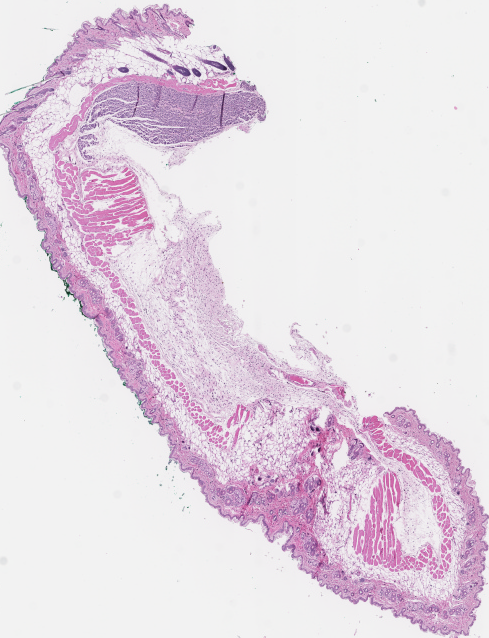

In [134]:
PIL.Image.fromarray(np.squeeze(px))